In [145]:
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
from utilities.triplet_generator import TripletGenerator
from utilities.mapping import MapFunction 
from utilities import visualization
import keras
from keras import Model
from keras import optimizers
from keras import metrics
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer

In [146]:
#HYPERPARAMETERS
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
max_triplets = 300
validation_triplets = 40

In [147]:
# Creating training generator

(418, 447, 3)


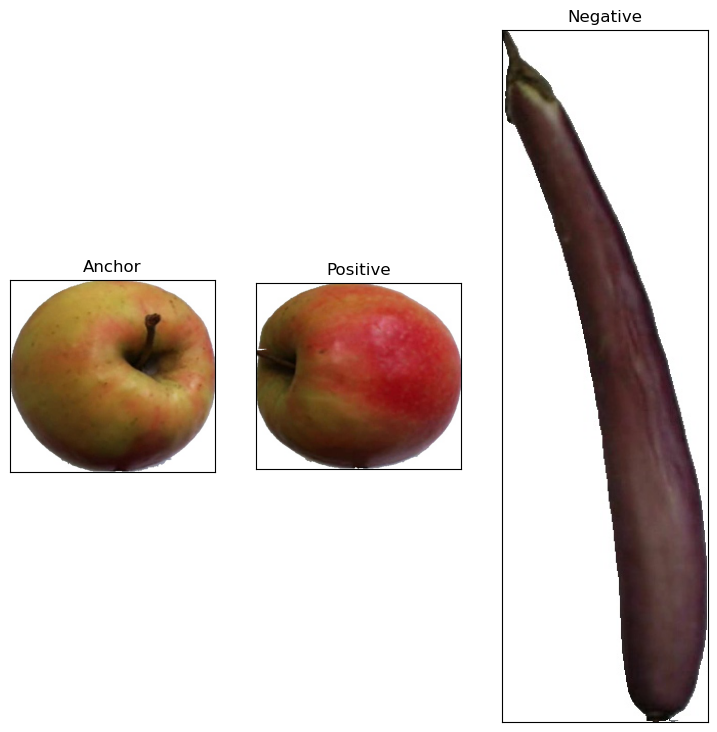

In [148]:
training_generator = TripletGenerator(r"C:\Users\matim\Documents\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Training", max_triplets)
training_generator.generate_all_fruits_dict()
photos_generator = training_generator.get_next_element()
photos = next(photos_generator)
a = mpimg.imread(photos[0])
p = mpimg.imread(photos[1])
n = mpimg.imread(photos[2])
print(a.shape)
visualization.visualize(a, p, n)

In [149]:
# Creating validation generator

(742, 601, 3)


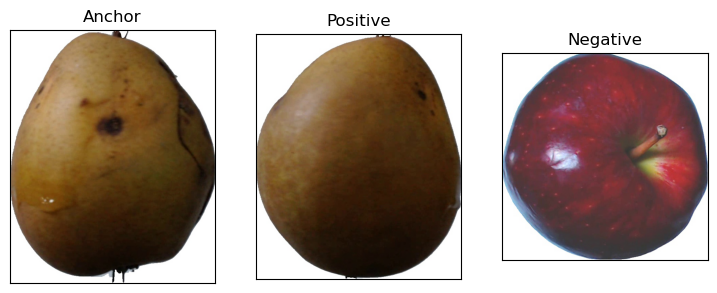

In [150]:
validation_generator = TripletGenerator(r"C:\Users\matim\Documents\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Validation", validation_triplets)
validation_generator.generate_all_fruits_dict()
photos_generator = validation_generator.get_next_element()
photos = next(photos_generator)
a = mpimg.imread(photos[0])
p = mpimg.imread(photos[1])
n = mpimg.imread(photos[2])
print(a.shape)
visualization.visualize(a, p, n)

In [151]:
# Creating training_dataset from generator

In [152]:
train_dataset = tf.data.Dataset.from_generator(training_generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string)))
print(train_dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [153]:
# Creating validation_dataset from generator

In [154]:
validation_dataset = tf.data.Dataset.from_generator(validation_generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string)))
print(validation_dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [155]:
# Mapping datasets and separating them into batches

In [156]:
mapped_training_dataset = train_dataset.map(lambda anchor, positive, negative: (MapFunction(image_size)(anchor,positive,negative))).batch(batch_size)
print(mapped_training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


In [157]:
mapped_validation_dataset = validation_dataset.map(lambda anchor, positive, negative: (MapFunction(image_size)(anchor,positive,negative))).batch(batch_size)
print(mapped_validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


In [158]:
# Visual verification of images from datasets

(100, 100, 3)


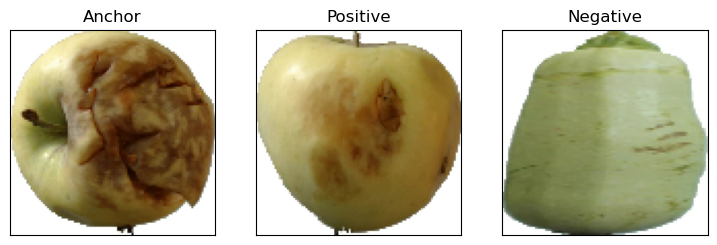

In [159]:
triplet_training = next(iter(mapped_training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

visualization.visualize(anchor_img, positive_img, negative_img)
print(anchor_img.shape)

(100, 100, 3)


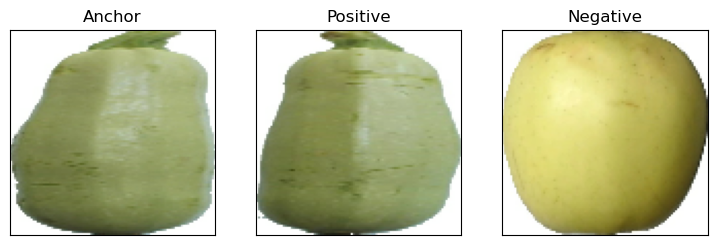

In [160]:
triplet_validation = next(iter(mapped_training_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')

visualization.visualize(anchor_img, positive_img, negative_img)
print(anchor_img.shape)

In [161]:
# Creating siamese model

In [162]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_model = keras.Model(input_layer, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu



In [163]:
# Adding merge layer and creating output layer

In [164]:
anchor_input = keras.layers.Input(name="anchor", shape=(100,100,3))
positive_input = keras.layers.Input(name="positive", shape=(100,100,3))
negative_input = keras.layers.Input(name="negative", shape=(100,100,3))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)
# tower_1 = embedding_network(anchor_input)
# tower_2 = embedding_network(positive_input)
# tower_3 = embedding_network(negative_input)

# merge_layer = keras.layers.Lambda(distance, output_shape=(1,))([tower_1, tower_2, tower_3])
# normal_layer = keras.layers.BatchNormalization()(merge_layer)
# output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)


In [165]:
# Compilation of our model and summary

In [166]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001))
# siamese_network.compile(optimizer="RMSprop")
siamese_network.summary()

Model: "siamese_model_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_23 (Functional)      │ ?                      │       230,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,902 (901.96 KB)

 Trainable params: 199,920 (780.94 KB)

 Non-trainable params: 30,982 (121.02 KB)

In [167]:
# Training 

In [168]:
siamese_network.fit(mapped_training_dataset, epochs=epochs, batch_size=batch_size, validation_data=mapped_validation_dataset)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - loss: 0.1911 - val_loss: 0.0566
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - loss: 0.0664 - val_loss: 0.0396
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.0694 - val_loss: 0.0569
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - loss: 0.0415 - val_loss: 0.0310
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - loss: 0.0535 - val_loss: 0.0119
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - loss: 0.0314 - val_loss: 0.0989
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.0251 - val_loss: 0.0282
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 0.0565 - val_loss: 0.0522
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 0.0372 - val_loss: 0.0488
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 0.0336 - val_loss: 0.0227


In [169]:
# Visualizing the next triplet

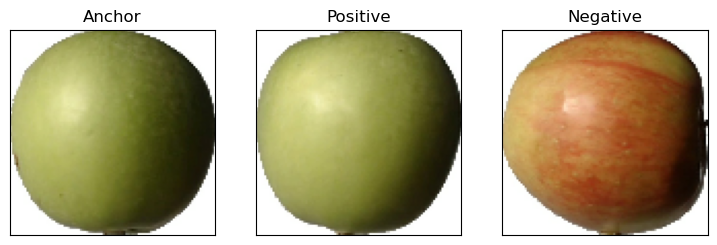

In [170]:
sample = next(iter(mapped_training_dataset))
anchor_img = np.asarray(sample[0][0]).astype('float32')
positive_img = np.asarray(sample[1][0]).astype('float32')
negative_img = np.asarray(sample[2][0]).astype('float32')

visualization.visualize(anchor_img, positive_img, negative_img)

In [171]:
# Evaluating the cosine similarity on trained model

In [172]:
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(anchor),
    embedding_model(positive),
    embedding_model(negative),
)
cosine_similarity = metrics.CosineSimilarity()

# Positive similarity should be larger than negative similarity
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9581202
Negative similarity 0.6458566
